## Import libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy.special import comb

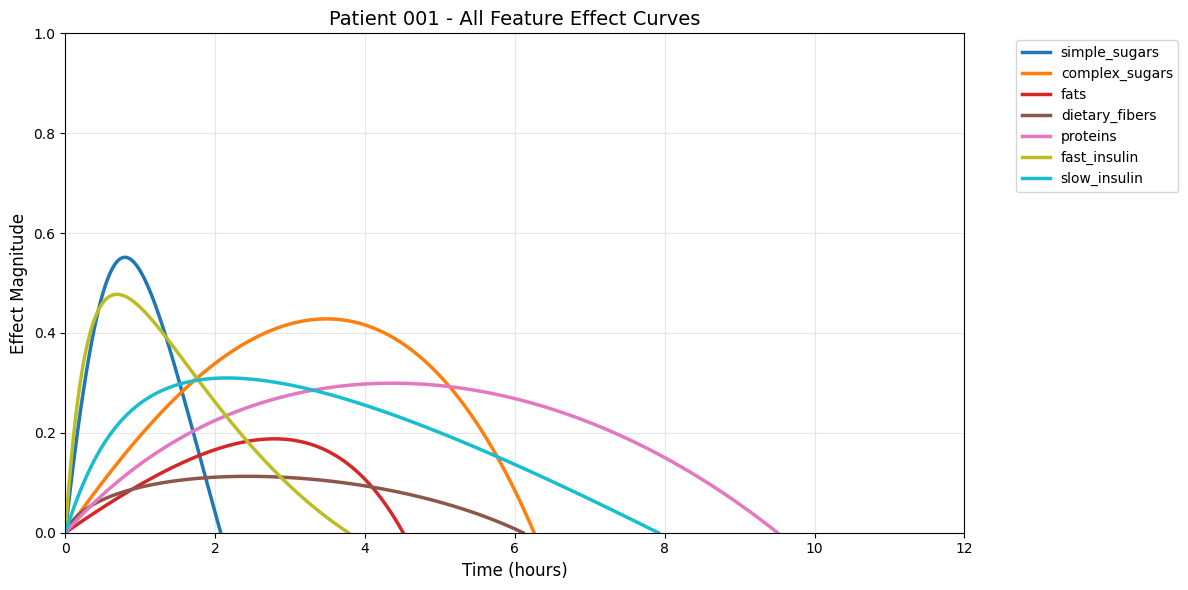

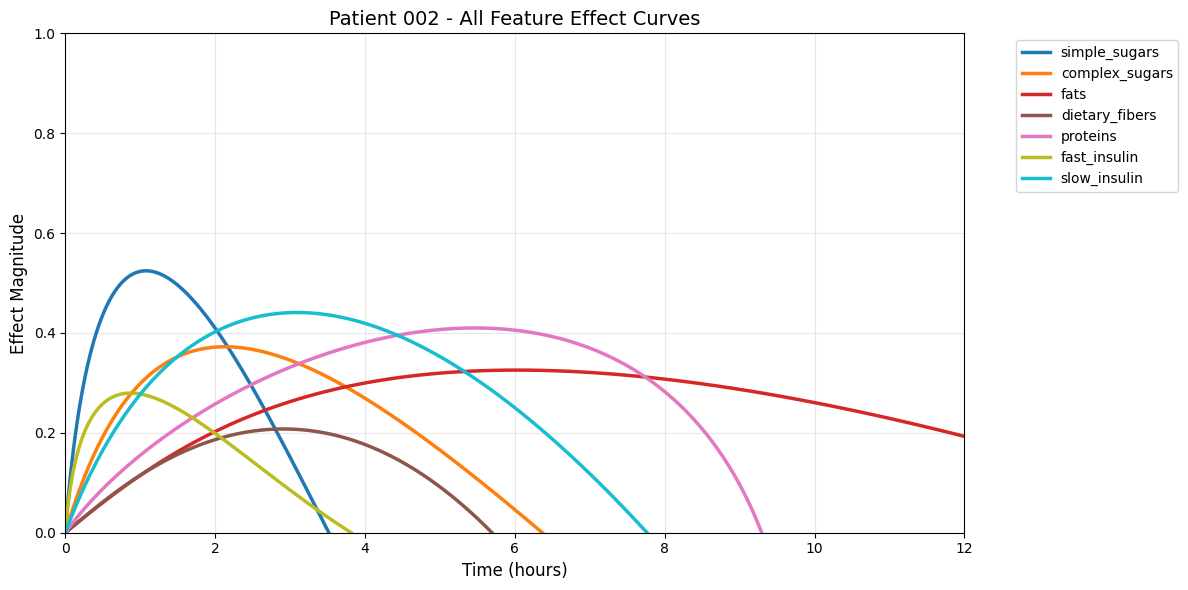

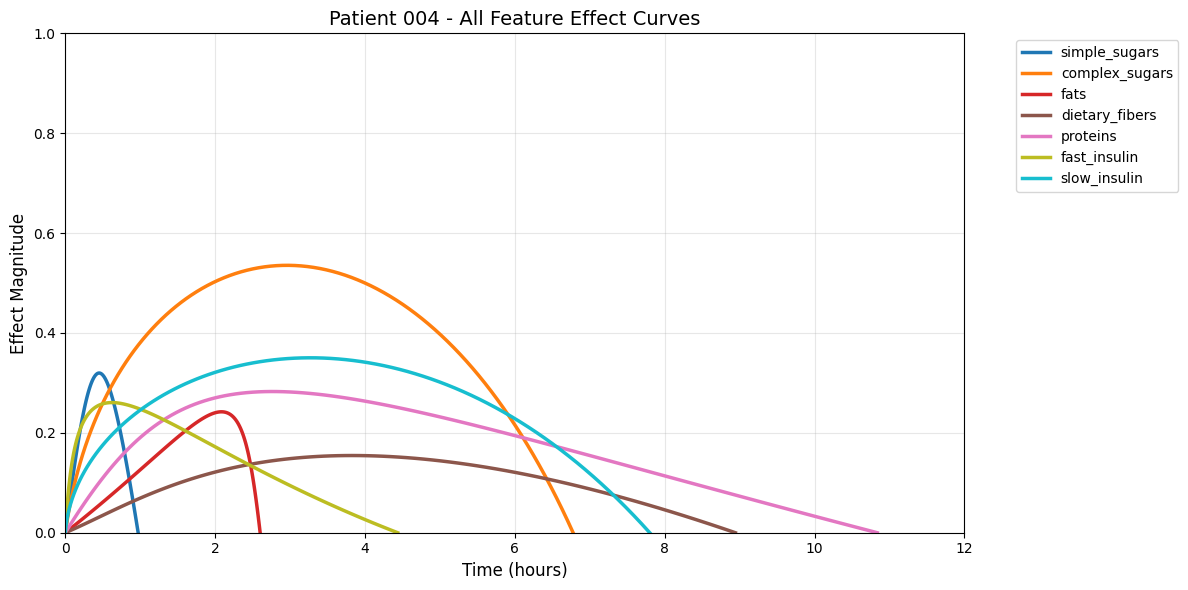

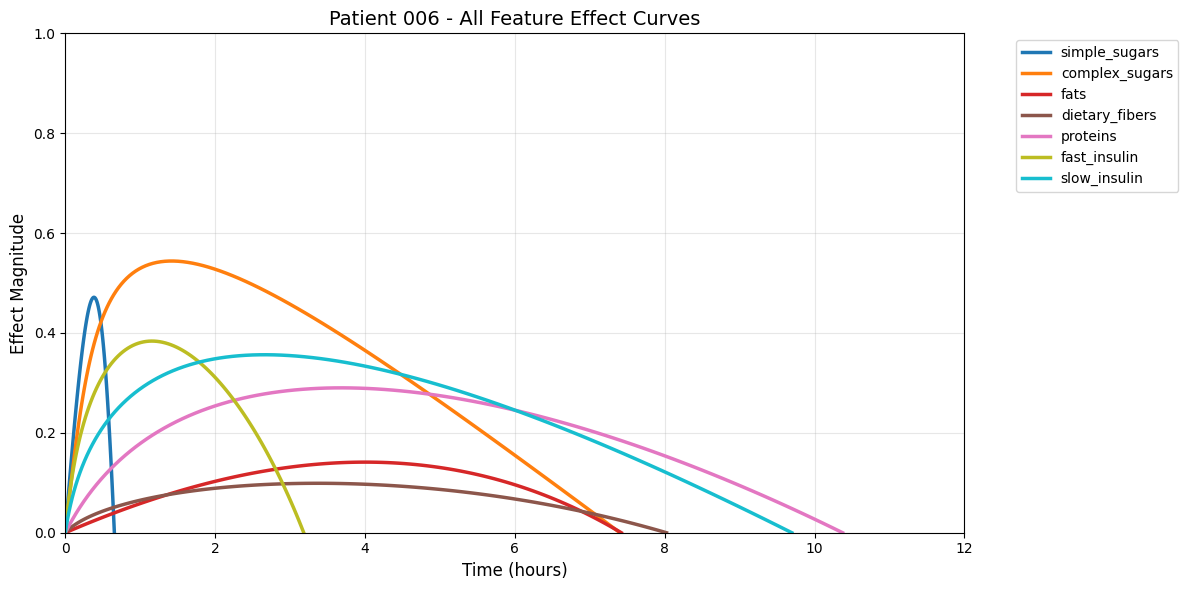

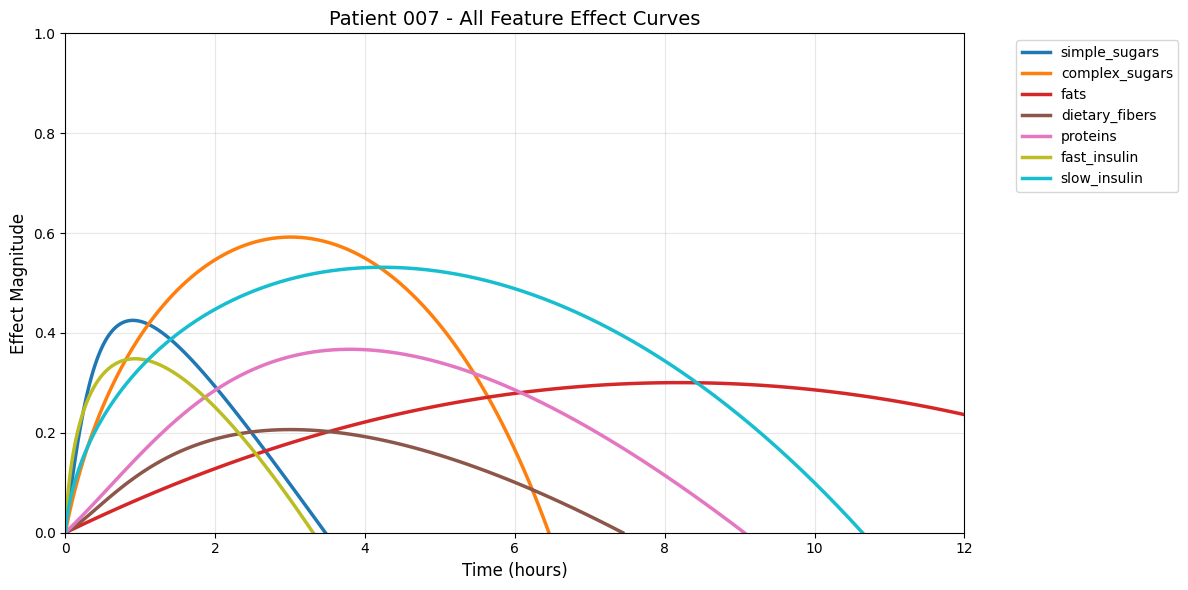

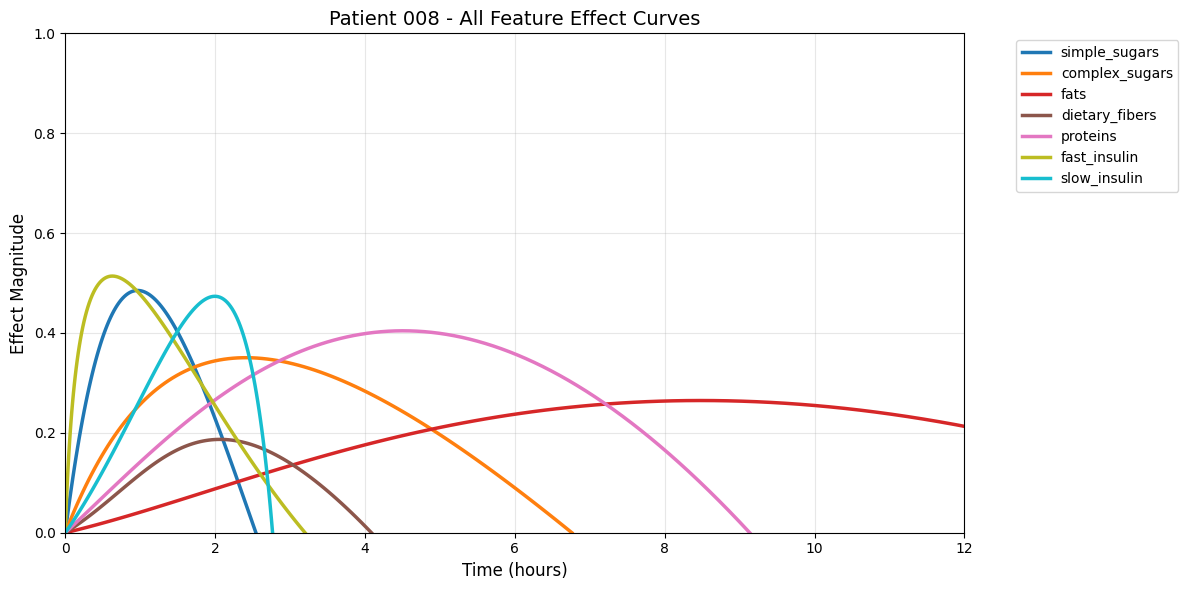

In [17]:
def bernstein_poly(i, n, t):
    return comb(n, i) * (t**i) * ((1-t)**(n-i))

def bezier_curve(points, num=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    
    for i, point in enumerate(points):
        curve += np.outer(bernstein_poly(i, n, t), point)
    
    return curve

# Load parameters
with open('parameters/patient_bezier_params.json', 'r') as f:
    params = json.load(f)

features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']

# Create output directory
os.makedirs('visualizations', exist_ok=True)

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(features)))
color_map = dict(zip(features, colors))

# Plot by patient - all features in one plot
for patient, feature_params in params.items():
    plt.figure(figsize=(12, 6))
    
    # Plot each feature
    for feature in features:
        if feature in feature_params:
            # Reshape parameters into control points
            control_points = np.array(feature_params[feature]).reshape(-1, 2)
            
            # Generate and plot Bezier curve
            curve = bezier_curve(control_points, num=100)
            plt.plot(curve[:, 0], curve[:, 1], '-', linewidth=2.5, 
                    label=feature, color=color_map[feature])
    
    plt.title(f'Patient {patient} - All Feature Effect Curves', fontsize=14)
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Effect Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 12)  # Limit x-axis to 12 hours for better visibility
    plt.ylim(0, 1)   # Normalize y-axis
    
    # Add legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

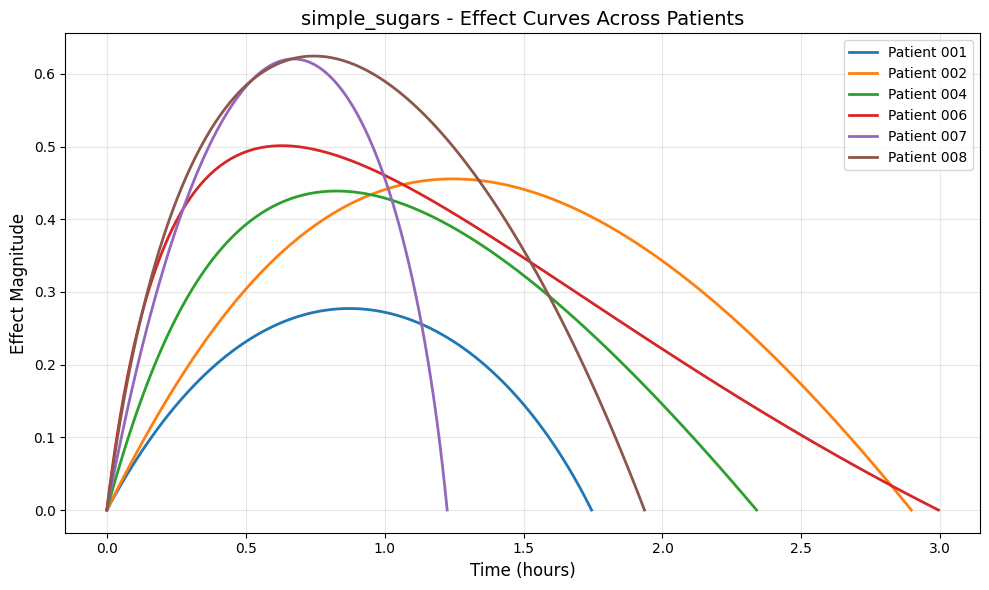

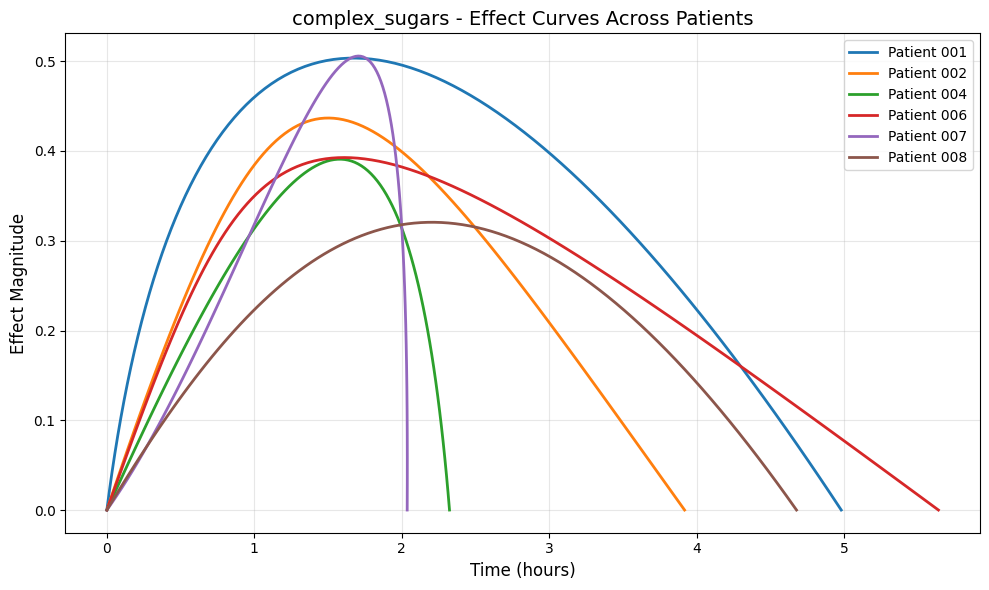

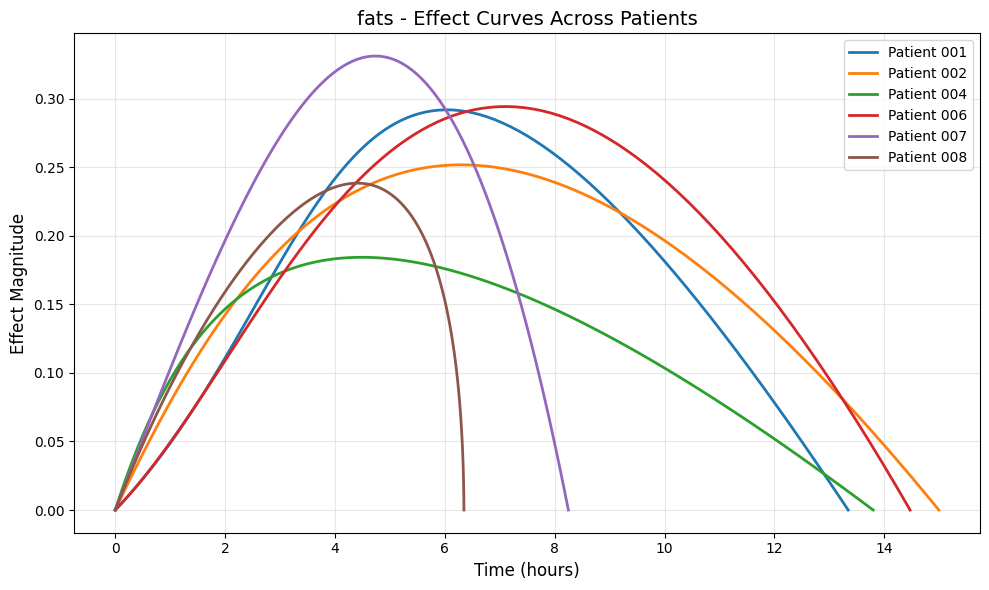

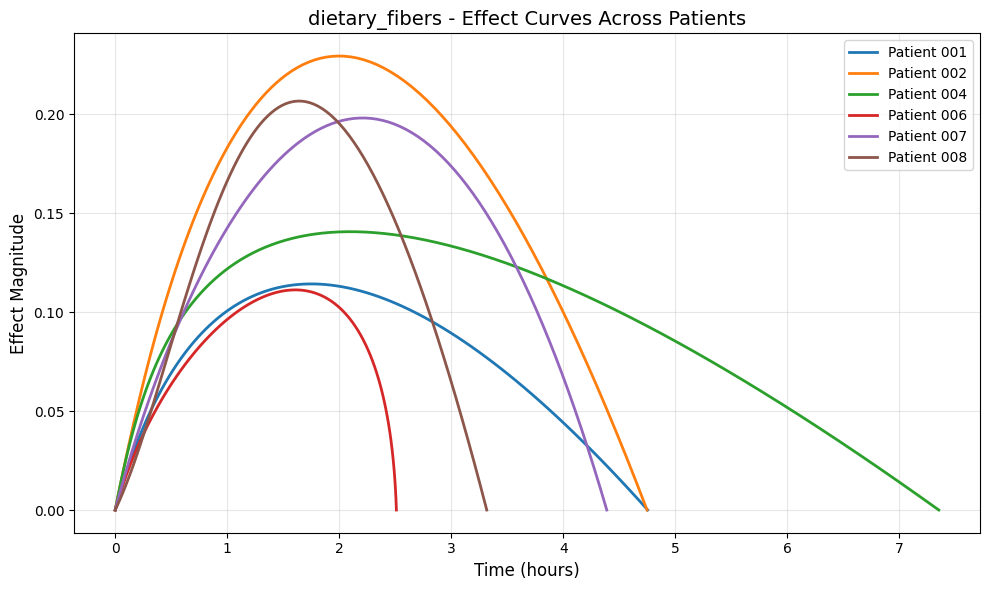

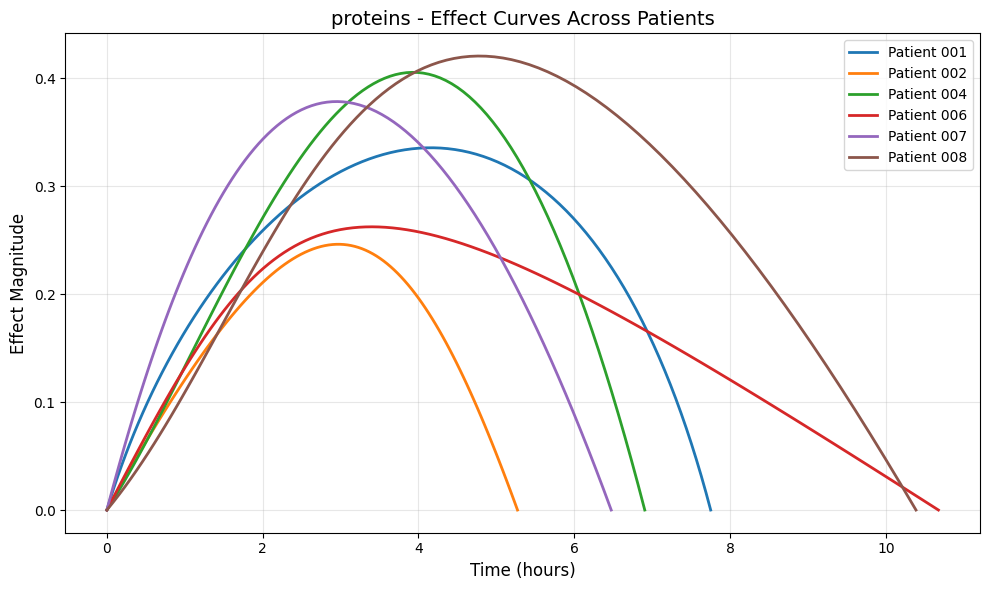

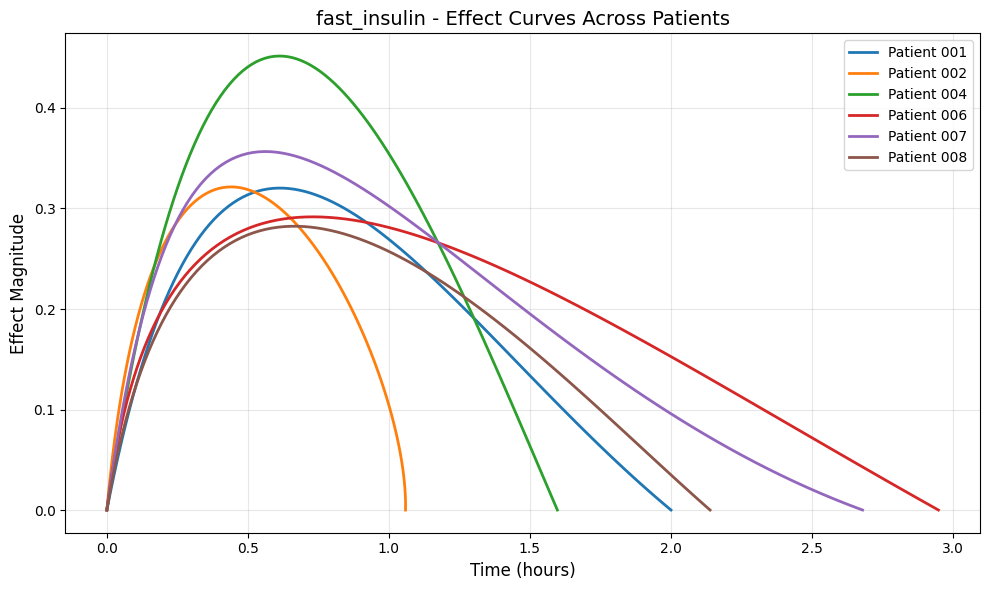

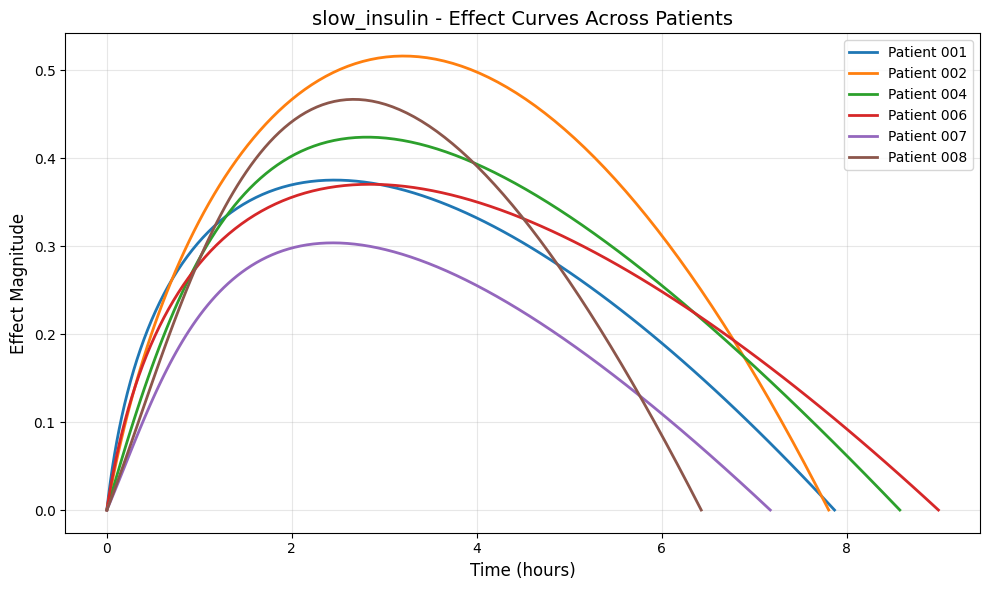

In [15]:
# Comparative visualization across patients
for feature in features:
    plt.figure(figsize=(10, 6))
    
    for patient, feature_params in params.items():
        if feature in feature_params:
            control_points = np.array(feature_params[feature]).reshape(-1, 2)
            curve = bezier_curve(control_points, num=100)
            plt.plot(curve[:, 0], curve[:, 1], '-', linewidth=2, label=f'Patient {patient}')
    
    plt.title(f'{feature} - Effect Curves Across Patients', fontsize=14)
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Effect Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()